In [124]:
import pandas as pd
data = pd.read_csv ('D:/NLP_Data/Data4Test.csv', encoding='ISO-8859-1')

0    93
1    57
Name: Label, dtype: int64
0.6129032258064516


C:\Users\tunji\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


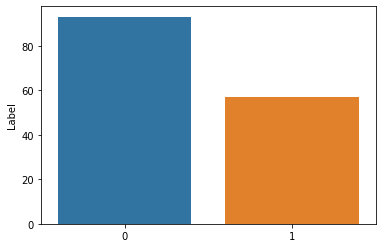

In [125]:
import seaborn as sns

x=data['Label'].value_counts()
print(x)
sns.barplot(x.index,x)

#plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/responseLabelBallance.jpg')
print(57/93)

In [126]:
#Function to balance the class
def balanceClassCategory (data,catColumn, cat_high, cat_low):
    #shuffled = df.sample(frac=1).reset_index()
    df = data.sample(frac=1).reset_index()
    df_cat_high= df[df['Label']== cat_high]
    df_cat_low = df[df['Label']== cat_low]
    df_cat_high_downsampled = df_cat_high.sample(df_cat_low.shape[0])
    df_balanced = pd.concat([df_cat_high_downsampled, df_cat_low])
    
    return df_balanced

In [127]:
data = balanceClassCategory (data, "Label", 0, 1)

0    57
1    57
Name: Label, dtype: int64


C:\Users\tunji\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

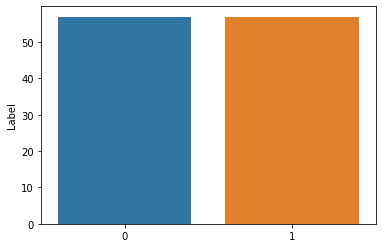

In [128]:
x=data['Label'].value_counts()
print(x)
sns.barplot(x.index,x)


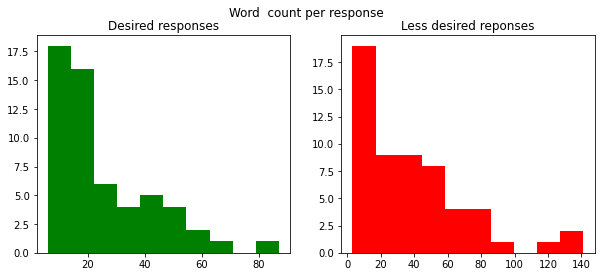

<Figure size 432x288 with 0 Axes>

In [129]:
# PLOTTING WORD-COUNT
import matplotlib.pyplot as plt

data['word_count'] = data['Response'].apply(lambda x: len(str(x).split()))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=data[data['Label']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Desired responses')
train_words=data[data['Label']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Less desired reponses')
fig.suptitle('Word  count per response')
plt.show()

plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/wordCountPerRespsonseIn_0_1.jpg')

In [130]:
import spacy
nlp = spacy.load("en_core_web_sm")

#the Brown Corpus text contains specific punctuation sequences 
#( `,and``) that should be removed. You can do that by adding the character sequences 
#to the list of stop words (easier than adding characters to the punctuation module)

nlp.Defaults.stop_words.add("`,")
nlp.Defaults.stop_words.add("``")

In [131]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [132]:
#Lematizaton that works with string 
#Return string of all the tokens, separated by spaces.
import nltk
#nltk.download()

def lemmatizeWorkingWithStrings(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    word_pos_tags = nltk.pos_tag(tokens) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return ' '.join(a)

In [133]:
data['clean_text'] = data['Response'].apply(lambda x: lemmatizeWorkingWithStrings(x))
#data.head(10)

In [134]:
from sklearn.model_selection import train_test_split
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(data["clean_text"],data["Label"],test_size=0.2,shuffle=True,stratify=data['Label'])

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Tf-Idf transformer

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [136]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)

y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

print('AUC:', roc_auc)
print ("Accuracy", accuracy_score(y_test, y_predict))
print ("F1-Score", f1_score(y_test, y_predict))
print ("Recall", recall_score(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.82      0.90        11

    accuracy                           0.91        23
   macro avg       0.93      0.91      0.91        23
weighted avg       0.93      0.91      0.91        23

Confusion Matrix: [[12  0]
 [ 2  9]]
AUC: 0.9242424242424242
Accuracy 0.9130434782608695
F1-Score 0.9
Recall 0.8181818181818182


In [137]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
from sklearn.naive_bayes import MultinomialNB
nb_tfidf = MultinomialNB()

nb_tfidf.fit(X_train_vectors_tfidf, y_train)

#Predict y value for test dataset
y2_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y2_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y2_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y2_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y2_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)
print ("Accuracy", accuracy_score(y_test, y2_predict))
print ("F1-Score", f1_score(y_test, y2_predict))
print ("Recall", recall_score(y_test, y2_predict))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.91      0.95        11

    accuracy                           0.96        23
   macro avg       0.96      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23

Confusion Matrix: [[12  0]
 [ 1 10]]
AUC: 0.9393939393939393
Accuracy 0.9565217391304348
F1-Score 0.9523809523809523
Recall 0.9090909090909091


In [142]:
#save the model to disk
import pickle

#filename = 'C:\\Users\\tunji\\CMUProject\\lrModel.sav'
#pickle.dump(lr_tfidf, open(filename, 'wb'))

In [143]:
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test_vectors_tfidf, y_test)
#print(result)

0.9130434782608695


In [144]:
#filename2 = 'C:\\Users\\tunji\\CMUProject\\nbModel.sav'
#pickle.dump(nb_tfidf, open(filename2, 'wb'))

In [148]:
#loaded_model = pickle.load(open(filename2, 'rb'))
#result = loaded_model.score(X_test_vectors_tfidf, y_test)
#print(result)
